In [87]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import numpy as np
from collections import defaultdict
import scipy

In [7]:
import skater

### Загружаем данные

In [8]:
test_merged = pd.read_csv('test_merged.csv')
train_merged = pd.read_csv('train_merged.csv')

In [9]:
X_train = train_merged.drop(['TARGET'], axis = 1)
X_test = test_merged.copy()
y_train = train_merged.TARGET.values
print('X_train shape:', X_train.shape)

X_train shape: (307511, 128)


### Обучаем модель

In [14]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc", 
                              max_depth=4,learning_rate=0.277, gamma=0.382)
xgb_model.fit(X_train, y_train)

XGBClassifier(eval_metric='auc', gamma=0.382, learning_rate=0.277, max_depth=4,
              random_state=42)

In [15]:
print(roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1]))

0.7662371085332839


### Делаем прогноз

In [16]:
submission = pd.read_csv('sample_submission.csv')
submission['TARGET'] =xgb_model.predict_proba(X_test)[:,1]
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.054460
1,100005,0.161407
2,100013,0.026001
3,100028,0.025872
4,100038,0.126772


In [17]:
submission.to_csv('my_submission.csv', index=False)

### Интерпретатор

In [18]:
import shap 

class BaseInterpretator:
    """
    Базовый класс интерпретатора
    """

    def __init__(self, model):
        """
        Создаёт объект интерпретатора
        :param model: Модель для интерпретации
        """
        self.__model = model
    
    def fit_shap(self):
        self.__explainer = shap.TreeExplainer(self.__model)
        return

    def shap(self, data, type = 'summary_plot', num_features = None):
        """
        Плейсхолдер для метода интепретации
        :param data: Данные, на которых построенна модель. Используются для отдельных видоп интепретации
        :return: Возвращает результат интепретации
        """
        if type == 'summary_plot':
            shap_values = self.__explainer.shap_values(data)
            return shap.summary_plot(shap_values, data, max_display = num_features)
        
        if type == 'summary_bar_plot':
            shap_values = self.__explainer.shap_values(data)
            return shap.summary_plot(shap_values, data, plot_type='bar', max_display = num_features)
        
        if type == 'individual_plot':
            shap.initjs()
            shap_value_sample = self.__explainer.shap_values(data)
            return shap.force_plot(self.__explainer.expected_value, shap_value_sample, data)

### Интерпретируем SHAP

In [47]:
import matplotlib.pyplot as plt

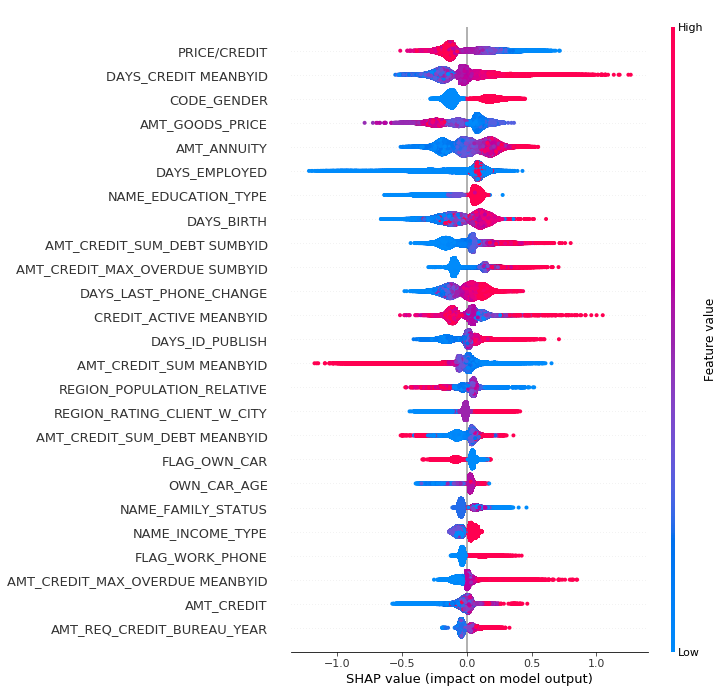

In [19]:
interp = BaseInterpretator(xgb_model)
interp.fit_shap()
interp.shap(X_train, type = 'summary_plot', num_features = 25)


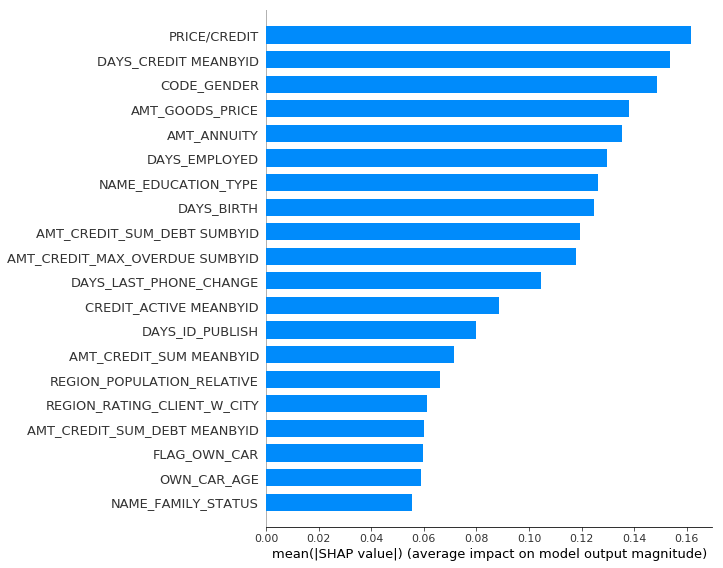

In [20]:
interp.shap(X_train, type = 'summary_bar_plot')

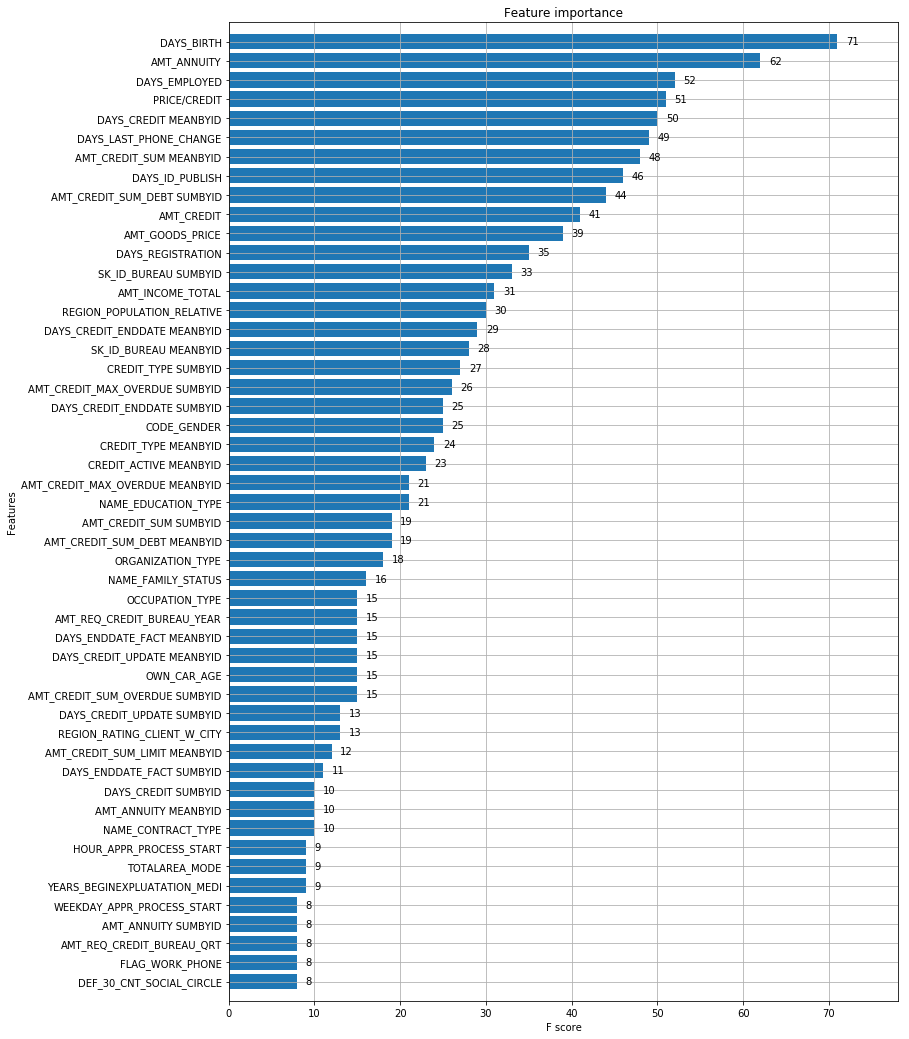

In [49]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [21]:
sample = X_train.sample(1,random_state=42)
interp.shap(sample, type = 'individual_plot')

In [22]:
sample = X_test.sample(1,random_state=42)
interp.shap(sample, type = 'individual_plot')

### Интерпретируем PDP`

В идеале хотим построить PDP между не очень сильно коррелирующими переменными

In [79]:
feature_importances = xgb_model.get_booster().get_score(importance_type="weight")

In [80]:
top_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:30]
top_features_names = [pair[0] for pair in top_features]

In [102]:
pdp_pairs = defaultdict(str)
for feature in top_features_names:
    for feature_2 in top_features_names:
        corr = scipy.stats.spearmanr(X_train[feature], X_train[feature_2])[0]
        if abs(corr) < 0.5:
            pdp_pairs[feature] = feature_2

In [103]:
pdp_pairs

defaultdict(str,
            {'DAYS_BIRTH': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'AMT_ANNUITY': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'DAYS_EMPLOYED': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'PRICE/CREDIT': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'DAYS_CREDIT MEANBYID': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'DAYS_LAST_PHONE_CHANGE': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'AMT_CREDIT_SUM MEANBYID': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'DAYS_ID_PUBLISH': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'AMT_CREDIT_SUM_DEBT SUMBYID': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'AMT_CREDIT': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'AMT_GOODS_PRICE': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'DAYS_REGISTRATION': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'SK_ID_BUREAU SUMBYID': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'AMT_INCOME_TOTAL': 'AMT_CREDIT_SUM_OVERDUE SUMBYID',
             'REGION_POPULATION_RELATI

In [44]:
df_corr = X_train.corr()

In [63]:
df_corr['AMT_GOODS_PRICE'][df_corr['AMT_GOODS_PRICE']>0.5]

AMT_CREDIT         0.986588
AMT_ANNUITY        0.774661
AMT_GOODS_PRICE    1.000000
Name: AMT_GOODS_PRICE, dtype: float64

2021-05-07 22:49:49,735 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[750/750] grid cells ████████████████████ Time elapsed: 188 seconds

[[<Figure size 1152x720 with 2 Axes>,

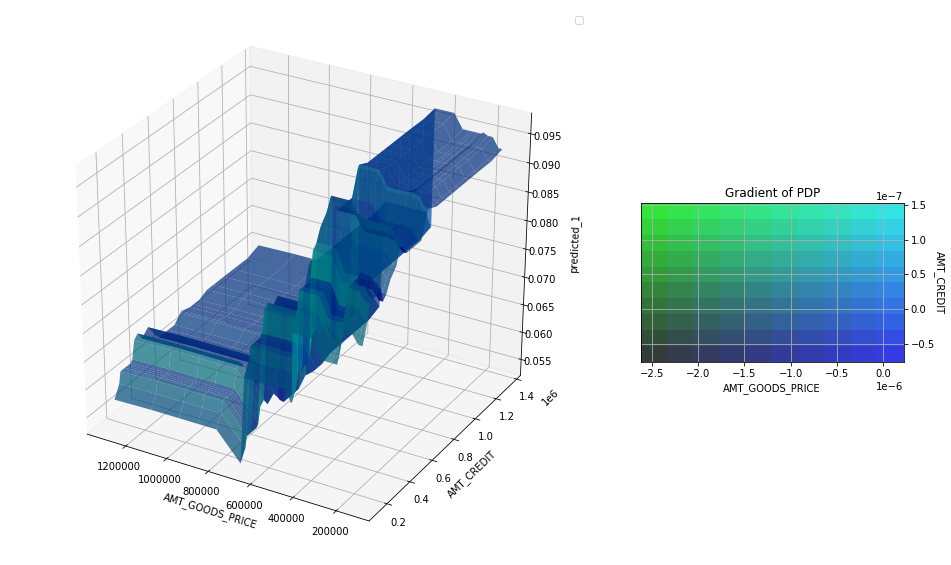

In [41]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

interpreter = Interpretation(X_train, feature_names = X_train.columns)
annotated_model = InMemoryModel(xgb_model.predict_proba, examples=X_train)
pdp_features = [('AMT_GOODS_PRICE', 'AMT_CREDIT')]
interpreter.partial_dependence.plot_partial_dependence(pdp_features, 
                                                       annotated_model,
                                                       grid_resolution=30,
                                                       n_samples=1000,
                                                       n_jobs=-1)

2021-05-07 22:57:14,414 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[750/750] grid cells ████████████████████ Time elapsed: 1152 seconds

[[<Figure size 1152x720 with 2 Axes>,

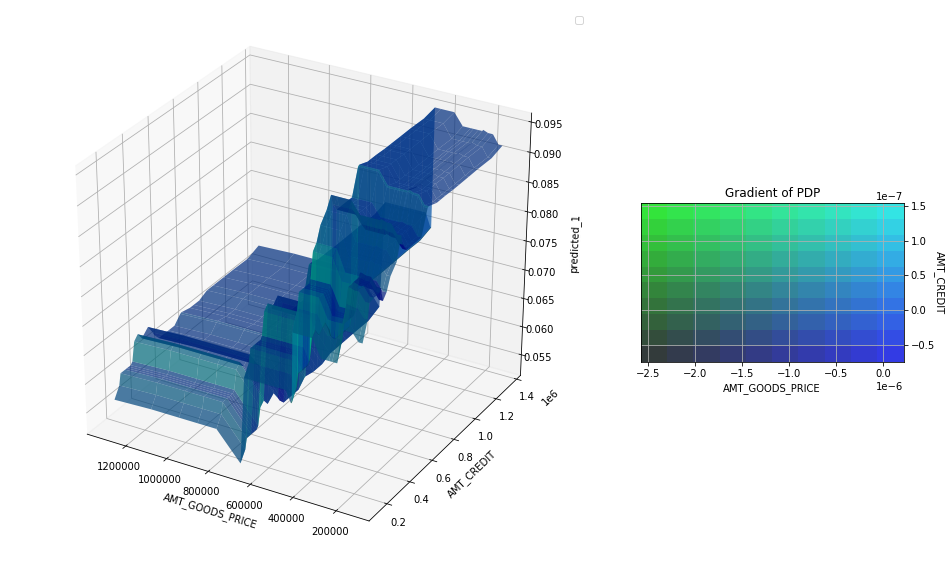

In [42]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

interpreter = Interpretation(X_train, feature_names = X_train.columns)
annotated_model = InMemoryModel(xgb_model.predict_proba, examples=X_train)
pdp_features = [('AMT_GOODS_PRICE', 'AMT_CREDIT')]
interpreter.partial_dependence.plot_partial_dependence(pdp_features, 
                                                       annotated_model,
                                                       grid_resolution=30,
                                                       n_samples=10000,
                                                       n_jobs=-1)